<h3> Predicting Forest Fires in Algeria</h3>


Forest fires are a type of  uncontrolled and unwanted fire that occurs in areas with a high amount of vegetation. Unlike controlled fires, which provides benefits for the ecology, these unwated forest fires usually have a negative impact, especially because they're harder to control. Drier, hotter conditions mean that forest fires are more likely to occur. In this project, we hope that we can predict whether a forest fire will occur when given weather information.


In 2007, forest fires in the Atlast Mountains, located on the northern coast of Algeria, killed several people as it spread rapidly due to hot, dry winds. Our dataset contains weather information on the Sidi Bel Abbès and the Bejaia region, and includes information such as :
- `day`,`month`,`year`: the date of the information
- `Temperature`: the maximum temperature in degrees celcius, ranging from 22 to 42
- `RH` : Relative humidity in percentages
- `Ws` : wind speed in kilometers per hour
- `Rain`: total amount of rain, in mm


The data set also includes other FWI (fire weather index) information, such as:
- `FFMC`: Fine Fuel Moisture Code
- `DMC` : dull Moisture Code
- `DC`: Drought Code 
-`ISI`: Initial Spread Index
-`BUI`: Buildup Index
-`FWI`: Fire Weather Index

Finally, under the `Classes` column, we can see whether or not there was fire.
For more information on FWI, [this website](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi) has a summary of what each index/code means.

Before we read the dataset, we need to load the necessary libraries:

In [159]:
library(tidyverse)
library(repr)
library(GGally)
library(tidymodels)

options(repr.matrix.max.rows = 6)

set.seed(123)

After inspecting the dataset, we can copy and paste the data set's download url from 
[this website](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++)
and download it to our notebook it using the `read_csv` function.

the dataset has 2 separate tables for the 2 regions, so we can make 2 datasets corresponding to them:

In [160]:
fire_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"
# this takes the bajaja region
forest_fire_bejaia <- read_csv(fire_url, skip = 1, n_max = 122)
# this takes the sidi region
forest_fire_sidi <- read_csv(fire_url, skip = 126)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

the 44th row on the sidi dataset has some errors, so we need to fix it:

In [164]:
forest_fire_sidi[44, 10] <- "14.6"
forest_fire_sidi[44, 11] <- 9
forest_fire_sidi[44, 12] <- 12.5
forest_fire_sidi[44, 13] <- "10.4"
forest_fire_sidi[44, 14] <- "fire"

Now, we change the column's data types with `as.numeric` and combine both datasets together with `rbind`.

In [165]:
forest_fire_sidi <-  forest_fire_sidi %>%
    mutate(DC = as.numeric(DC)) %>%
    mutate(FWI = as.numeric(FWI))

forest_fires <- rbind(forest_fire_sidi, forest_fire_bejaia)

Since we want to predict if there is fire or no fire, we also need to change  `Classes`  into a factor, using `mutate` and `as_factor`. 

In [166]:
forest_fires <- forest_fires %>%
    mutate(Classes = as_factor(Classes))

forest_fires

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire
02,06,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,not fire
03,06,2012,29,80,14,2.0,48.7,2.2,7.6,0.3,2.6,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,32,47,14,0.7,77.5,7.1,8.8,1.8,6.8,0.9,not fire
29,09,2012,26,80,16,1.8,47.4,2.9,7.7,0.3,3.0,0.1,not fire
30,09,2012,25,78,14,1.4,45.0,1.9,7.5,0.2,2.4,0.1,not fire


In [ ]:
Now, we split our data into the training and test data sets:

In [168]:
#We don't want the date columns: our explanation will be given later!
forest_fires <- forest_fires %>%
    select(Temperature:Classes)

fire_split <- initial_split(forest_fires, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

with `map_df`, we can see the min, max and average of each numeric column to see how it looks. By using the `range` argument, we can see both min and max values.

In [169]:
forest_fire_training_range <- fire_train %>%
    select(Temperature:FWI) %>%
    map_df(range)

forest_fire_training_mean <- fire_train %>%
    select(Temperature:FWI) %>%
    map_df(mean)

forest_fire_training_range
forest_fire_training_mean

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,21,8,0.0,30.5,0.7,7.0,0,1.1,0.0
40,90,22,16.8,94.3,65.9,210.4,19,68.0,31.1


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
32.03804,62.1087,15.55435,0.7472826,77.62935,14.60652,48.11359,4.729891,16.47989,6.954348


However, it's hard to draw anything conclusive based on just these numbers. It would've been easier to make decisions based on visual information. So, we want to draw plots that compare two columns with each other... for all the 15 columns. Because doing it manually will be hard, we used `ggpairs` from the `GGally` library that we already loaded.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



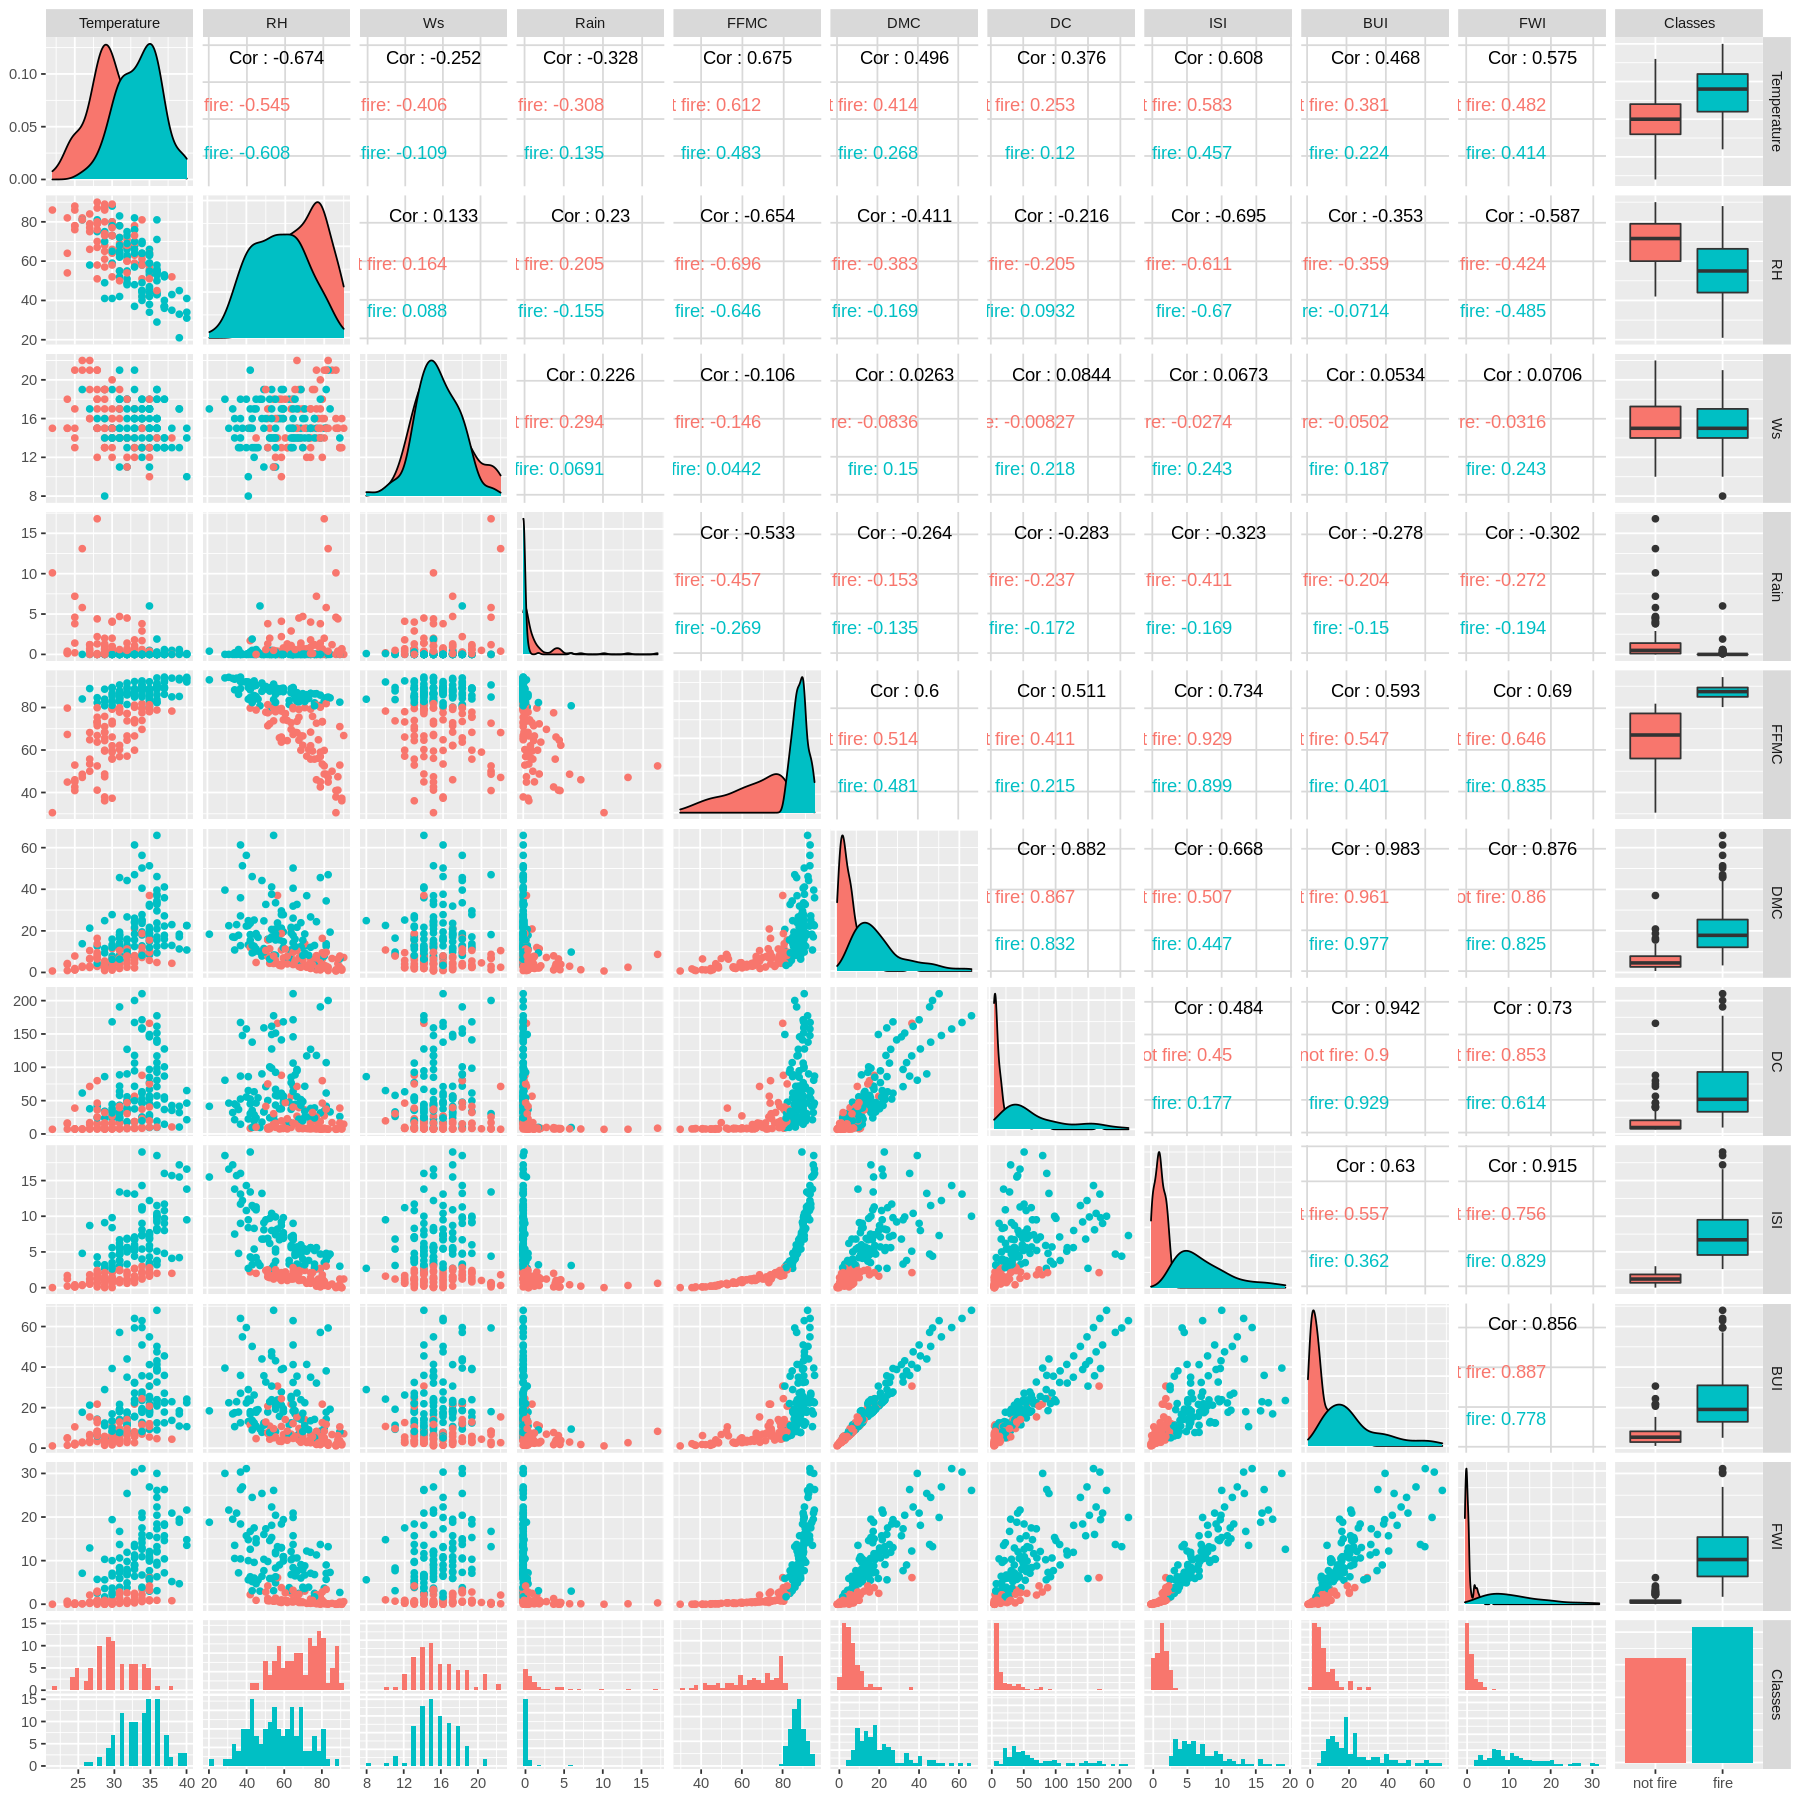

In [175]:
options(repr.plot.width=15, repr.plot.height=15)
fire_train %>% 
    ggpairs(aes(color = Classes))

Since all of this occured in 2012 we decided not to use the `day`, `month` and `year` columns. The FWI information (FFMC, DMC, DC, ISI, BUI, and FWI) are calculated based on temperature, relative humidity, wind and rain. `ISI` is calculated from Ws and FFMC, and `BUI` is calculated from DMC and DC. Therefore, these 2 columns "contain" information from other columns too. Moreover, based on the `ggpairs` plots, we can see that there is a relationship between `ISI`, `BUI` and `Classes`. `FWI` is calculated using `ISI` and `BUI` values, but we want at least 2 predictors, so we use `ISI` and `BUI` to predict the `Classes`.


We can visualise our results using a scatter plot that shows the `ISI` and `BUI` values on the axes, and color coded based on the `Classes`.

**Expected outcomes and significance:**

In this project, we expect to find a model that can predict with enough accuracy whether or not a fire will occur based on the weather information given. We hope that in the future, something like this will be used in real life to predict future fires. Predicting fire, especially if it's quite accurate, can be beneficial because it means we can mobilise firefighters faster, which might help stop the spread of fires. It means less resources spent fighting the fire, less damage to the ecosystem - and most importantly less lives lost. Hopefully, this can also lead to other questions, such as whether or not we can predict the magnitude of a forest fire.
